In [4]:
import os
import cv2  # For image processing
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For displaying images
import pandas as pd
import geopandas as gpd
import os
import shutil
import glob
import pickle

import rasterio
from rasterio.plot import reshape_as_image
from rasterio.features import rasterize

from shapely.geometry import mapping, Point, Polygon
from shapely.ops import unary_union

import matplotlib.pyplot as plt

from typing import Iterable, Any, List, Tuple, Callable

In [39]:
class FeatureMatcher:
    def __init__(self):
        self.sift = cv2.SIFT_create()
        self.bf = cv2.BFMatcher()

    def _normalize_image(self, img: np.ndarray) -> np.ndarray:
        '''normalize if images are larger than uint8'''
        if img.max() > 255:
            img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        return img.astype(np.uint8)

    def find_features_px(self, img1: np.ndarray, img2: np.ndarray):
        '''feature matching for images'''
        img1 = self._normalize_image(img1)
        img2 = self._normalize_image(img2)

        if len(img1.shape) > 2:
            img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
        if len(img2.shape) > 2:
            img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

        kp1, des1 = self.sift.detectAndCompute(img1, None)
        kp2, des2 = self.sift.detectAndCompute(img2, None)

        return img1, img2, kp1, des1, kp2, des2

    def find_features_path(self, img_path_1: str, img_path_2: str):
        '''feature matching but from path'''
        img1 = cv2.imread(img_path_1, cv2.IMREAD_UNCHANGED)
        img2 = cv2.imread(img_path_2, cv2.IMREAD_UNCHANGED)

        if img1 is None or img2 is None:
            raise ValueError(f"Images at {img_path_1} or {img_path_2} could not be opened.")
        
        return self.find_features_px(img1, img2)

    def compare_features(self, des1, des2, threshold=0.75):
        '''filter good matches pairwise'''
        matches = self.bf.knnMatch(des1, des2, k=2)
        good_matches = [m for m, n in matches if m.distance < threshold * n.distance]
        
        print(f"Found {len(good_matches)} good matches.")
        return good_matches

    def draw_matches(self, img1, img2, threshold=0.75):
        '''the name of function speaks for itself'''
        img1, img2, kp1, des1, kp2, des2 = self.find_features_path(img1, img2)
        good_matches = self.compare_features(des1, des2, threshold)

        matched_img = cv2.drawMatches(
            img1, kp1, img2, kp2, good_matches, None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
            matchColor=(0,255,0),
            singlePointColor=(255,0,0),
            matchesThickness=2 
        )

        return matched_img

In [10]:
def load_and_display_images(image_path1, image_path2):
    # Load images
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)

    # Convert images to RGB for display
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # Display images side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(img1)
    ax1.set_title('Image 1')
    ax1.axis('off')

    ax2.imshow(img2)
    ax2.set_title('Image 2')
    ax2.axis('off')
    
    plt.show()

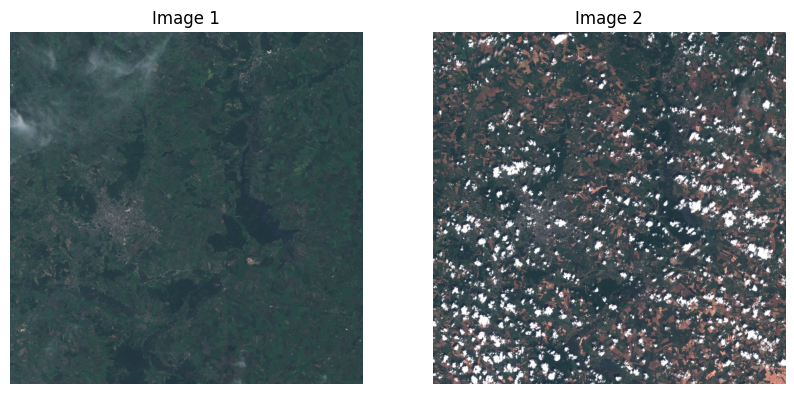

In [35]:
img_path_1 = './dev_dataset/T36UYA_20160621T084012_TCI.jpg'
img_path_2 = './dev_dataset/T36UYA_20190701T083609_TCI.jpg'
load_and_display_images(img_path_1, img_path_2)

Found 5 good matches.


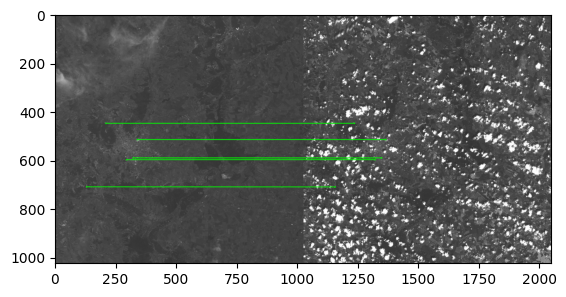

In [40]:
f_matcher = FeatureMatcher()

matched_images = f_matcher.draw_matches(img_path_1, img_path_2, threshold=0.75)
plt.imshow(matched_images, cmap='gray')